# hypothesis 2: republicans use specifically christian language more

# load data and imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os

tqdm.pandas()

In [3]:
DATA_PATH = "/data/laviniad/congress_errata/classed_congress_df.json"
df = pd.read_json(DATA_PATH)
df['date'] = pd.to_datetime(df['date'].apply(str), format='%Y%m%d')
df['month'] = df['date'].dt.month

In [ ]:
raw_df = df.copy()

# filter

In [ ]:
def is_dem_rep(t):
    return (t == 'Democrat') or (t == 'Republican')

def not_procedural_unknown_topic(x):
    return (not ('Procedural' in x)) and (not ('Unknown' in x))

def is_long(x, thresh=5): # takes string, whitespace heuristic
    return len(x.split()) > thresh

def is_in_range(x):
    return x in range(1995, 2023)

df = df[df['party'].progress_apply(is_dem_rep)]
#df = df[df['main_topic'].progress_apply(not_procedural_unknown_topic)]
df = df[df['year'].progress_apply(is_in_range)]
df = df[df['text'].progress_apply(is_long)]

  0%|          | 0/1328805 [00:00<?, ?it/s]

  0%|          | 0/1203575 [00:00<?, ?it/s]

  0%|          | 0/1182286 [00:00<?, ?it/s]

In [ ]:
print(f"Filtered out {len(raw_df) - len(df)} rows")
print(f"New length: {len(df)}")

Filtered out 147411 rows
New length: 1181394


In [ ]:
print("Getting 118th Congress df")
df_118 = raw_df[raw_df['congress_num'] == 118]
df_118 = df_118[df_118['party'].progress_apply(is_dem_rep)]
df_118 = df_118[df_118['text'].progress_apply(is_long)]

Getting 118th Congress df


  0%|          | 0/25825 [00:00<?, ?it/s]

  0%|          | 0/21289 [00:00<?, ?it/s]

In [ ]:
palette = {'Democrat': 'blue', 'Republican': 'red', 'New Progressive': 'grey', 'Popular Democrat': 'grey', 'Independence Party (Minnesota)': 'grey', 'Anti-Jacksonian': 'grey', 'Independent': 'green', 'unknown': 'black', 'Democrat Farmer Labor': 'blue'}
sns.set(context="notebook", font_scale=1.8, rc={'figure.figsize':(12,10)}, style='whitegrid')

# keyword analyses

In [ ]:
# getting type of each keyword

df['christian'] = df['num_christian'] / df['length']
df['general'] = df['num_general'] / df['length']

aggregate = df.groupby(['year', 'party']).agg({'general': 'mean', 'christian': 'mean', 'num_general': 'sum', 'num_christian': 'sum', 'length': 'sum'}).reset_index()
stds = df.groupby(['year', 'party']).agg({'general': 'std', 'christian': 'std'}).reset_index()

aggregate['general_std'] = stds['general']
aggregate['christian_std'] = stds['christian']

In [ ]:
# contingency matrix of speeches w respect to binary var: use both general and christian, neither, only general, or only christian

def get_type(row):
    if row['num_christian'] > 0 and row['num_general'] > 0:
        return 'both'
    elif row['num_christian'] == 0 and row['num_general'] == 0:
        return 'neither'
    elif row['num_christian'] > 0 and row['num_general'] == 0:
        return 'christian'
    elif row['num_christian'] == 0 and row['num_general'] > 0:
        return 'general'
    
    # impossible
    return None

df['type'] = df.apply(get_type, axis=1)

# contingency matrix of party and type
from scipy.stats import chi2_contingency
contingency = pd.crosstab(df['party'], df['type'])
c, p, dof, expected = chi2_contingency(contingency)
print(f"Chi2: {c}, p: {p}, dof: {dof}")

Chi2: 399.42964546417215, p: 2.94237468002231e-86, dof: 3


In [ ]:
print(contingency)

type        both  christian  general  neither
party                                        
Democrat    1273        914    16454   598485
Republican  1539        705    18240   543784


In [ ]:
contingency['sum'] = contingency.sum(axis=1)

In [ ]:
contingency

type,both,christian,general,neither,sum
party,,,,,
Democrat,1273,914,16454,598485,617126
Republican,1539,705,18240,543784,564268


In [ ]:
proportions = contingency.div(contingency['sum'], axis=0) * 100
print(proportions)


type            both  christian   general    neither    sum
party                                                      
Democrat    0.206279   0.148106  2.666230  96.979385  100.0
Republican  0.272743   0.124941  3.232507  96.369810  100.0


In [ ]:
df.head()

,bio_id,congress_num,year,date,chamber,speaker,text,month_code,month,gender,...,old_lexical,old_num_general,old_num_christian,old_binary_lex,lr_label_prop_religious,max_lr_prob,avg_lr_prob,christian,general,type
0,L000397,116,2019,2019-01-04,House,Ms. LOFGREN,"Ms. LOFGREN. Madam Speaker, I rise today to ho...",1,1,F,...,0.007673,3,0,True,0.0,0.025757,0.025757,0.0,0.002558,general
1,W000804,116,2019,2019-01-04,House,Mr. WITTMAN,"Mr. WITTMAN. Madam Speaker, I was not present ...",1,1,M,...,0.000000,0,0,False,0.0,0.000569,0.000569,0.0,0.000000,neither
2,S001201,116,2019,2019-01-04,House,Mr. SUOZZI,"Mr. SUOZZI. Madam Speaker, today is former Con...",1,1,M,...,0.000000,0,0,False,0.0,0.000002,0.000002,0.0,0.000000,neither
3,S001199,116,2019,2019-01-04,House,Mr. SMUCKER,"Mr. SMUCKER. Madam Speaker, I regret I was una...",1,1,M,...,0.000000,0,0,False,0.0,0.006180,0.006180,0.0,0.000000,neither
4,U000031,116,2019,2019-01-04,House,Mr. UPTON,"Mr. UPTON. Madam Speaker, I was unavoidably de...",1,1,M,...,0.000000,0,0,False,0.0,0.024203,0.024203,0.0,0.000000,neither


/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

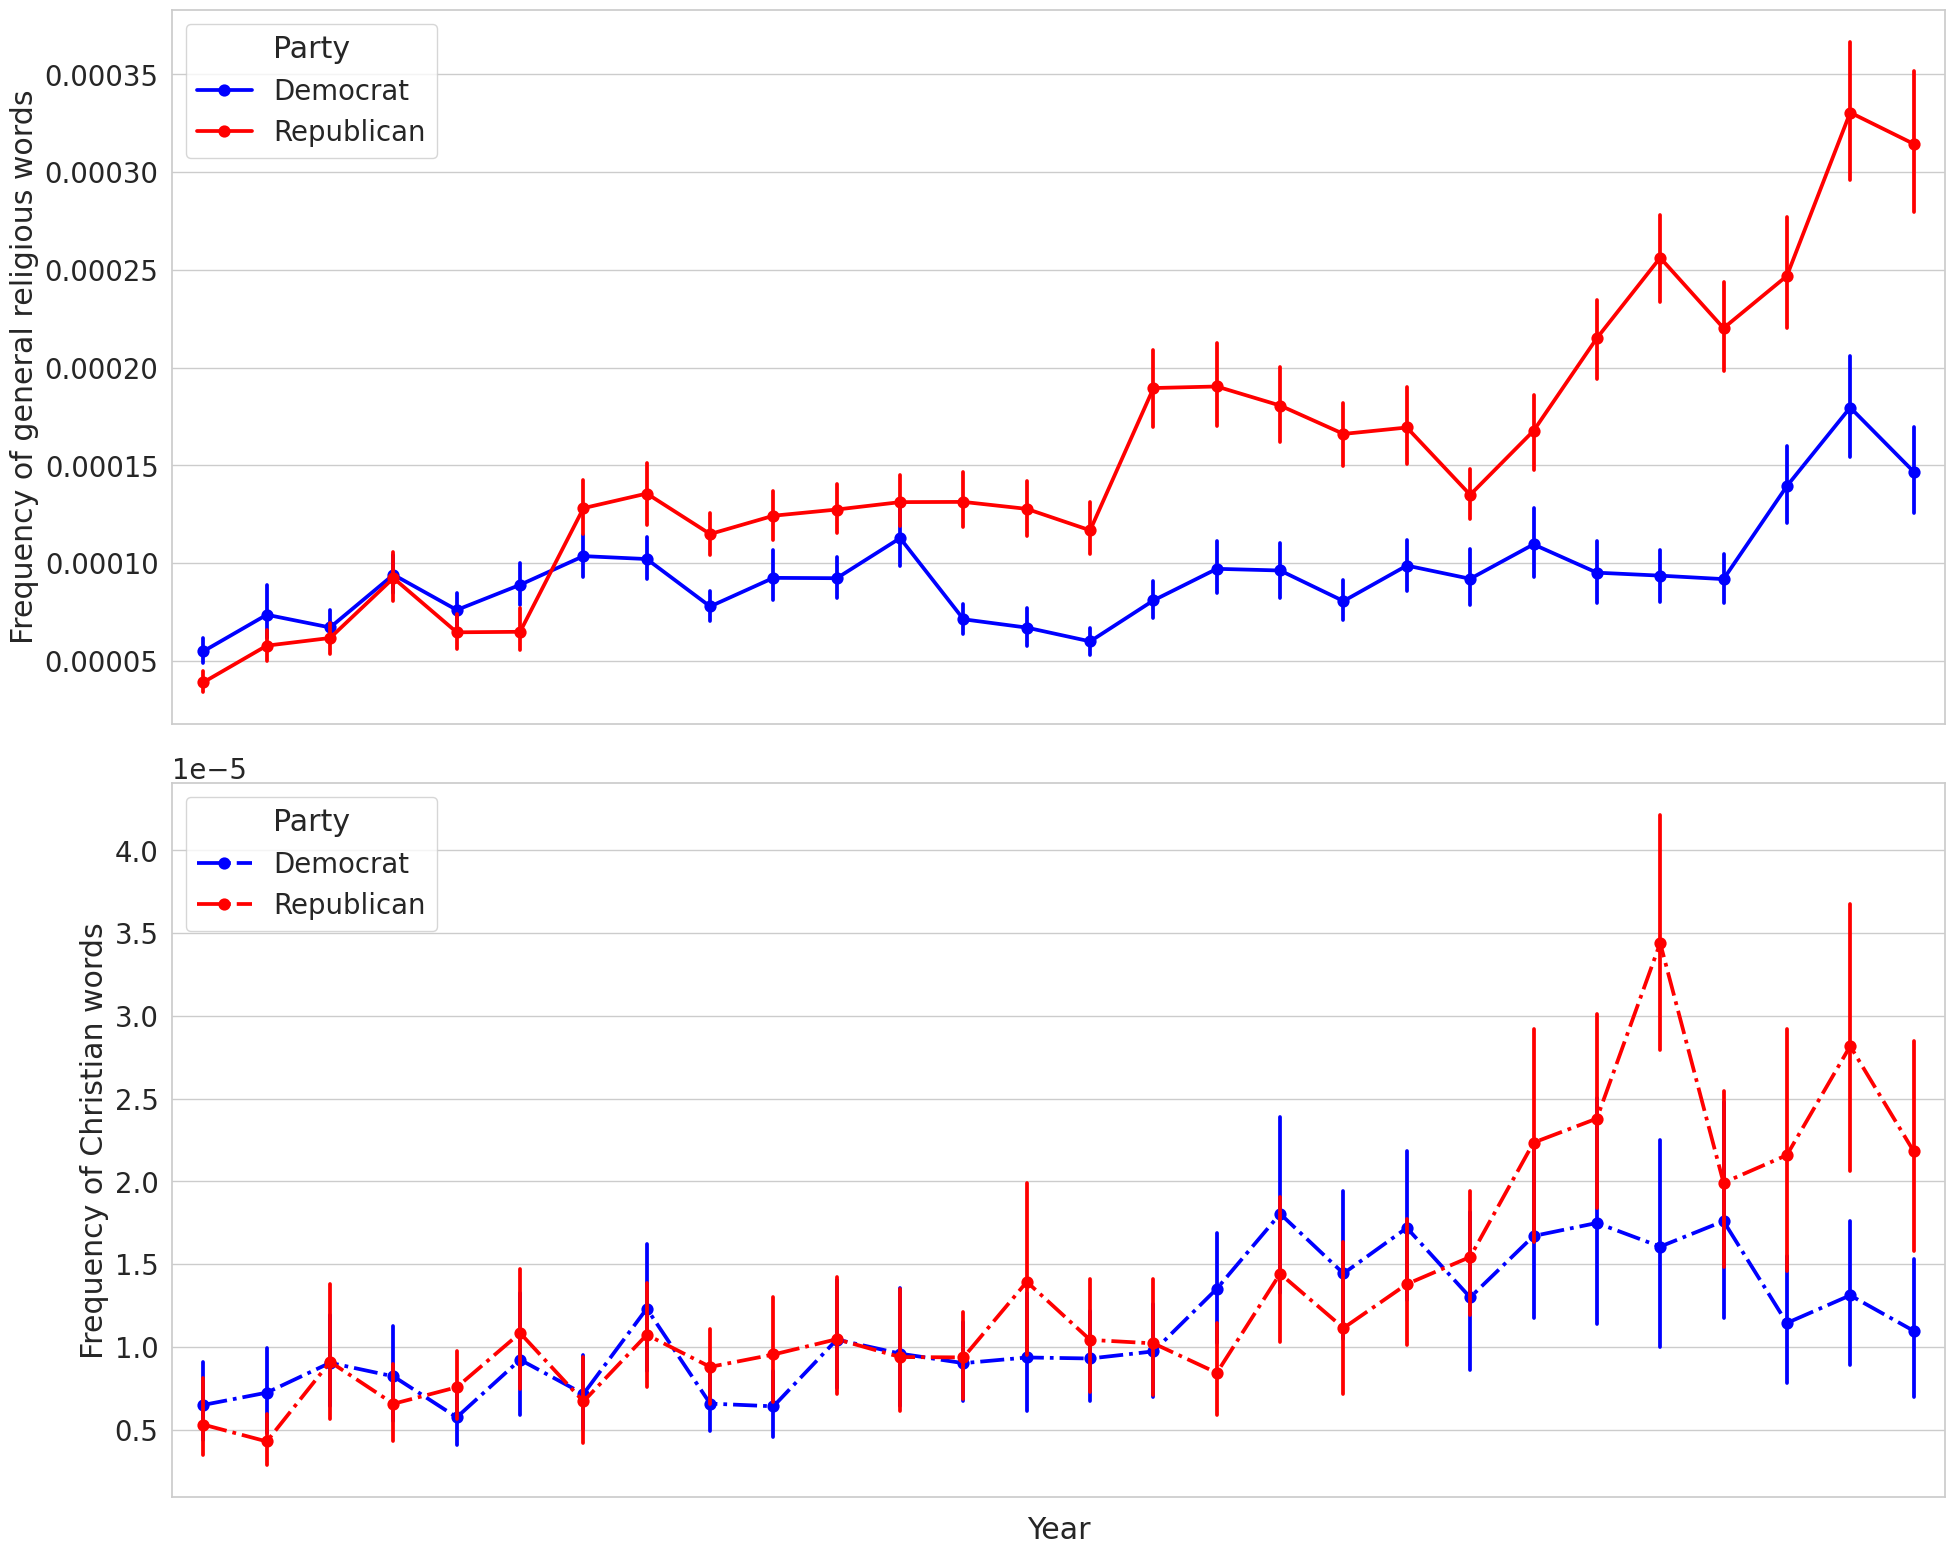

In [ ]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 16), sharex=True)

# Create the first subplot
sns.pointplot(data=df, x='year', y='general', hue='party', palette=palette, ax=ax1)

# Create the second subplot
sns.pointplot(data=df, x='year', y='christian', hue='party', palette=palette, linestyle='dashdot', ax=ax2)

# Set labels and legends
ax1.set_ylabel('Frequency of general religious words')
ax1.legend(title='Party')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

ax2.set_ylabel('Frequency of Christian words')
ax2.legend(title='Party')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.xlabel('Year')
plt.tight_layout()
plt.show()

# BR analyses

In [17]:
import pickle as pkl
import re
from data.bible_utils import comp_bible_helper
import nltk

In [18]:
MPNET_RESULTS = '/data/laviniad/sermons-ir/modeling/mpnet_results'
with open(MPNET_RESULTS + "/data.pkl", "rb") as f:
    data = pkl.load(f)

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

bible_df = comp_bible_helper()
pop_verses = pd.read_csv('/home/laviniad/projects/religion_in_congress/data/most_popular_verses.csv')
n = 500 # VERY generous
pop_citations = list(pop_verses['verse'].iloc[1:n+1])
bible_df['King James Bible'] = bible_df['King James Bible'].apply(remove_tags) # KJV in this df has italics etc
bible_df['Verse'] = bible_df['Verse'].apply(lambda x: x.lower())
limited_bible_df = bible_df[bible_df['Verse'].apply(lambda x: x in pop_citations)]
limited_verses = limited_bible_df['King James Bible']
verse_df = [{'text': t['King James Bible'], 'citation': t['citation']} for idx,t in limited_bible_df.iterrows()]
verse_df = pd.DataFrame(verse_df)
print(f"Number of verses: {len(verse_df.index)}")
limited_verse_to_citation = dict(zip(limited_verses, limited_bible_df['Verse']))
limited_citation_to_verse = {v.lower(): k for k,v in limited_verse_to_citation.items()}

br_df = pd.read_csv(MPNET_RESULTS + '/results_NEW.csv')
br_df['congress_idx'] = br_df['congress_idx'].apply(lambda x: x.replace('tensor(', '').replace(')', '')).apply(int)

def get_year(congress_idx):
    if congress_idx in df.index:
        return df.loc[(congress_idx,'year')]
    else:
        return 'unlabeled'

br_df['year'] = br_df['congress_idx'].apply(get_year)

def get_party(congress_idx):
    if congress_idx in df.index:
        return df.loc[(congress_idx,'party')]
    else:
        return 'unlabeled'

br_df['party'] = br_df['congress_idx'].apply(get_party)

br_df['is_rep'] = (br_df['party'] == 'Republican').apply(int)

def get_speaker(congress_idx):
    idx_key = congress_idx
    if idx_key in df.index:
        speaker = df.loc[idx_key]['speaker']
        return speaker
    else:
        return 0

br_df['speaker'] = br_df['congress_idx'].progress_apply(get_speaker)

def get_date(congress_idx):
    idx_key = congress_idx
    if idx_key in df.index:
        speaker = df.loc[idx_key]['date']
        return speaker
    else:
        return 0

br_df['date'] = br_df['congress_idx'].progress_apply(get_date)

filtered = br_df[br_df['cosine_similarity'] > 0.8]

Number of verses: 499


  0%|          | 0/1390465 [00:00<?, ?it/s]

  0%|          | 0/1390465 [00:00<?, ?it/s]

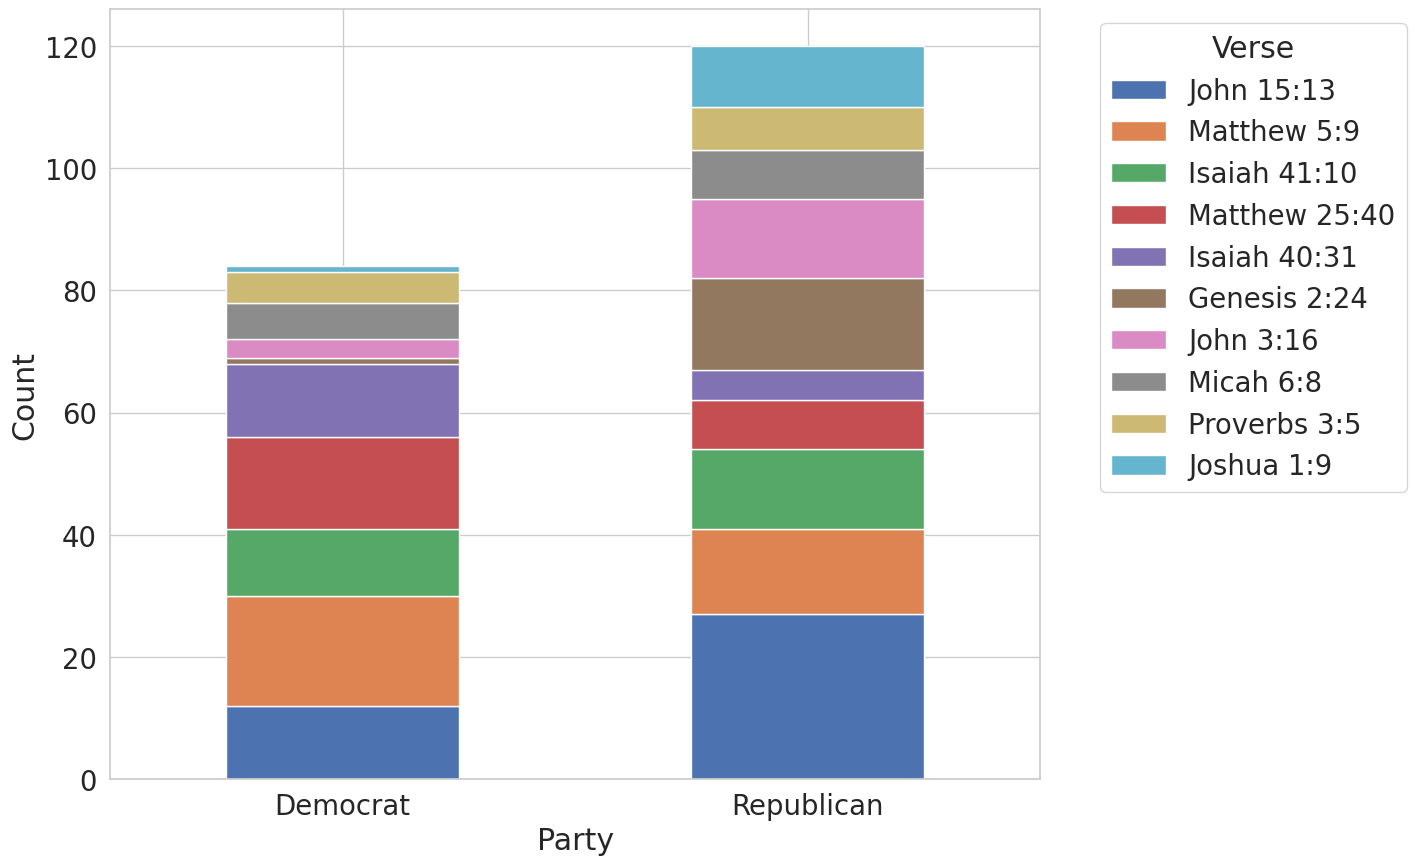

In [19]:
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.8)
filtered = filtered[(filtered['party'] == 'Democrat') | (filtered['party'] == 'Republican')]
verse_citations = filtered['verse_citation'].unique()
dummies = pd.get_dummies(filtered['verse_citation'])
filtered_scores = pd.concat([filtered, dummies], axis=1)

filtered_scores.head()
# Get the 10 most popular verse_citation columns
top_10_verse_citations = filtered_scores[verse_citations].sum().nlargest(10).index

# Filter the dataframe to include only the top 10 verse_citation columns
top_10_filtered_scores = filtered_scores[['party'] + list(top_10_verse_citations)]

# Calculate the counts for each verse_citation column
counts_by_party = top_10_filtered_scores.groupby('party')[top_10_verse_citations].sum()

# Plot the counts by party
counts_by_party.plot(kind='bar', stacked=True)
plt.xlabel('Party')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Verse', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [20]:
# table of top 10 verses by party

# Get the 10 most popular verse_citation columns
top_10_verse_citations = filtered_scores[verse_citations].sum().nlargest(10).index

# Filter the dataframe to include only the top 10 verse_citation columns
top_10_filtered_scores = filtered_scores[['party'] + list(top_10_verse_citations)]

# Calculate the counts for each verse_citation column
counts_by_party = top_10_filtered_scores.groupby('party')[top_10_verse_citations].sum()

# generate latex table
print(counts_by_party.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & John 15:13 & Matthew 5:9 & Isaiah 41:10 & Matthew 25:40 & Isaiah 40:31 & Genesis 2:24 & John 3:16 & Micah 6:8 & Proverbs 3:5 & Joshua 1:9 \\
party &  &  &  &  &  &  &  &  &  &  \\
\midrule
Democrat & 12 & 18 & 11 & 15 & 12 & 1 & 3 & 6 & 5 & 1 \\
Republican & 27 & 14 & 13 & 8 & 5 & 15 & 13 & 8 & 7 & 10 \\
\bottomrule
\end{tabular}



In [21]:
print(counts_by_party.transpose().to_latex())

\begin{tabular}{lrr}
\toprule
party & Democrat & Republican \\
\midrule
John 15:13 & 12 & 27 \\
Matthew 5:9 & 18 & 14 \\
Isaiah 41:10 & 11 & 13 \\
Matthew 25:40 & 15 & 8 \\
Isaiah 40:31 & 12 & 5 \\
Genesis 2:24 & 1 & 15 \\
John 3:16 & 3 & 13 \\
Micah 6:8 & 6 & 8 \\
Proverbs 3:5 & 5 & 7 \\
Joshua 1:9 & 1 & 10 \\
\bottomrule
\end{tabular}



In [22]:
counts_by_party

,John 15:13,Matthew 5:9,Isaiah 41:10,Matthew 25:40,Isaiah 40:31,Genesis 2:24,John 3:16,Micah 6:8,Proverbs 3:5,Joshua 1:9
party,,,,,,,,,,
Democrat,12,18,11,15,12,1,3,6,5,1
Republican,27,14,13,8,5,15,13,8,7,10


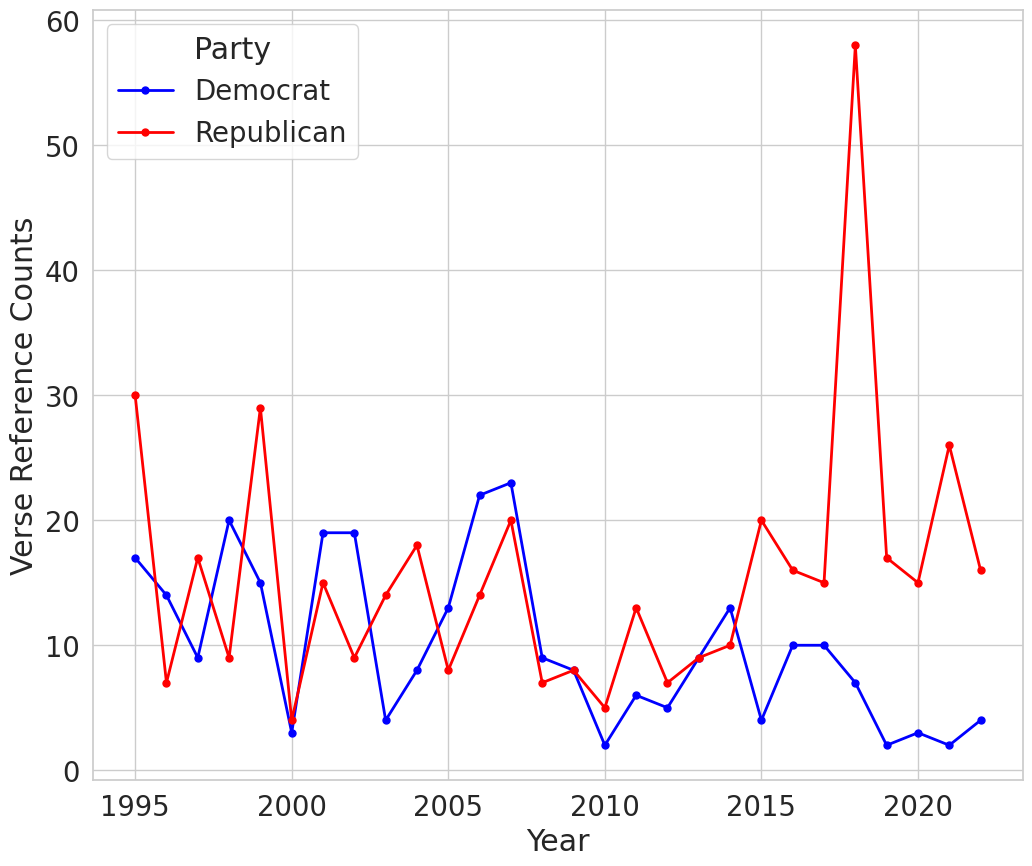

In [23]:
verse_counts = filtered.groupby(['year', 'party']).size().unstack(fill_value=0)
verse_counts.plot(kind='line', marker='o', color=['blue', 'red'], linestyle='-', linewidth=2, markersize=5)
plt.xlabel('Year')
plt.ylabel('Verse Reference Counts')
plt.legend(title='Party')
plt.show()

In [24]:
filtered['count'] = 1

In [25]:
filtered.columns

Index(['Unnamed: 0', 'congress_idx', 'text', 'most_similar_verse',
       'cosine_similarity', 'verse_citation', 'year', 'party', 'is_rep',
       'speaker', 'date', 'count'],
      dtype='object')

In [26]:
df.columns

Index(['bio_id', 'congress_num', 'year', 'date', 'chamber', 'speaker', 'text',
       'month_code', 'month', 'gender', 'party', 'state', 'is_in_senate',
       'main_topic', 'is_abortion', 'is_immigration', 'is_christianity',
       'is_science_technology', 'is_health_insurance', 'enclosing_county',
       'perc_adherents', 'religion', 'is_republican', 'church_in_bio',
       'dw_nom_1', 'dw_nom_2', 'lexical', 'num_general', 'num_christian',
       'length', 'binary_lex', 'full_state', 'state_perc_white',
       'state_perc_black', 'god', 'bible', 'jesus', 'faith', 'pray',
       'old_lexical', 'old_num_general', 'old_num_christian', 'old_binary_lex',
       'lr_label_prop_religious', 'max_lr_prob', 'avg_lr_prob', 'christian',
       'general', 'type'],
      dtype='object')

In [27]:
def get_state(cidx):
    if cidx in df.index:
        return df.loc[cidx]['state']
    else:
        return 'unlabeled'

def get_chamber(cidx):
    if cidx in df.index:
        return df.loc[cidx]['chamber']
    else:
        return 'unlabeled'
    
def get_bio_id(cidx):
    if cidx in df.index:
        return df.loc[cidx]['bio_id']
    else:
        return 'unlabeled'

filtered['state'] = filtered['congress_idx'].progress_apply(get_state)
filtered['chamber'] = filtered['congress_idx'].progress_apply(get_chamber)
filtered['bio_id'] = filtered['congress_idx'].progress_apply(get_bio_id)

  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/716 [00:00<?, ?it/s]

In [28]:
agg_filtered = filtered.groupby(['bio_id']).agg({'cosine_similarity': 'mean', 'speaker': 'first', 'count': 'sum', 'party': 'first', 'state': 'first', 'year': ['min', 'max']}).reset_index()

In [29]:
agg_filtered.head()

bio_id cosine_similarity       speaker count       party state  year      
                        mean         first   sum       first first   min   max
0  A000055          0.837933  Mr. ADERHOLT     9  Republican    AL  1999  2022
1  A000069          0.814294     Mr. AKAKA     5    Democrat    HI  1998  2005
2  A000355          0.806153   Mr. ABRAHAM     1  Republican    MI  1999  1999
3  A000356          0.878763  Mr. ASHCROFT     1  Republican    MO  1995  1995
4  A000358          0.816127      Mr. AKIN     3  Republican    MO  2005  2009

In [30]:
import json

path = '/data/laviniad/congress_bioguides.jsonlist'
obj_list = {}

with open(path, 'r') as f:
    for l in f.readlines():
        obj = json.loads(l.strip())
        # get most recent term
        year_died = None
        if "deathDate" in obj.keys():
            year_died = obj["deathDate"]
        if (year_died == None) or (year_died == "") or (not (int(year_died[:4]) < 1995)): # hasn't died before 1995
            party = obj["party"]
            most_recent = obj['jobPositions'][-1] # resulting obj has "job" field and "congressAffiliation" field, which itself has "congress" and "partyAffiliation" and "represents"
            if "represents" in most_recent["congressAffiliation"].keys():
                state = most_recent["congressAffiliation"]["represents"]["regionCode"]
            else:
                print(most_recent["congressAffiliation"])
                state = "unlabeled"
            chamber = most_recent["job"]["name"]
            full_name = obj["givenName"] + " " + obj["familyName"]

            most_recent = most_recent["congressAffiliation"]["congress"]
            most_early = obj["jobPositions"][0]["congressAffiliation"]["congress"]

            if "startDate" in most_early.keys():
                if "endDate" in most_recent.keys():
                    time_in_congress = "(" + most_early["startDate"][:4] + "-" + most_recent["endDate"][:4] + ")"
                else:
                    time_in_congress = "(" + most_early["startDate"][:4] + "-" + "2024" + ")"
            else:
                print("***")
                time_in_congress = "(unlabeled)"

            obj_list[obj["usCongressBioId"]] = {"full_name": full_name, "party": party, "state": state, "chamber": chamber, "time_in_congress": time_in_congress}

{'congress': {'name': 'The 105th United States Congress', 'congressNumber': 105, 'congressType': 'USCongress', 'startDate': '1997-01-03', 'endDate': '1999-01-03'}, 'partyAffiliation': [{'party': {'name': 'Republican'}, 'startCirca': False, 'endCirca': False}], 'caucusAffiliation': [{'party': {'name': 'Republican'}, 'startCirca': False, 'endCirca': False}]}
{'congress': {'congressNumber': 118, 'congressType': 'USCongress', 'name': 'The 118th United States Congress', 'startDate': '2023-01-03'}, 'partyAffiliation': [{'party': {'name': 'Republican'}, 'startCirca': False, 'endCirca': False}]}
{'congress': {'name': 'The 101st United States Congress', 'congressNumber': 101, 'congressType': 'USCongress', 'startDate': '1989-01-03', 'endDate': '1991-01-03'}, 'partyAffiliation': [{'party': {'name': 'Democrat'}, 'startCirca': False, 'endCirca': False}], 'caucusAffiliation': [{'party': {'name': 'Democrat'}, 'startCirca': False, 'endCirca': False}]}
{'congress': {'name': 'The 103rd United States Con

In [31]:
len(obj_list)

2577

In [32]:
agg_filtered['full_name'] = agg_filtered['bio_id'].progress_apply(lambda x: obj_list.get(x, {"full_name": "unknown"})["full_name"])
agg_filtered['time_in_congress'] = agg_filtered['bio_id'].progress_apply(lambda x: obj_list.get(x, {"time_in_congress": "unknown"})["time_in_congress"])

def get_min_and_max(time_in_congress):
    return [int(e) for e in time_in_congress[1:-1].split("-")]

agg_filtered['year_min'] = agg_filtered['time_in_congress'].apply(lambda x: get_min_and_max(x)[0])
agg_filtered['year_max'] = agg_filtered['time_in_congress'].apply(lambda x: get_min_and_max(x)[1])

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

In [33]:
agg_filtered

bio_id cosine_similarity         speaker count       party state  year  \
                          mean           first   sum       first first   min   
0    A000055          0.837933    Mr. ADERHOLT     9  Republican    AL  1999   
1    A000069          0.814294       Mr. AKAKA     5    Democrat    HI  1998   
2    A000355          0.806153     Mr. ABRAHAM     1  Republican    MI  1999   
3    A000356          0.878763    Mr. ASHCROFT     1  Republican    MO  1995   
4    A000358          0.816127        Mr. AKIN     3  Republican    MO  2005   
..       ...               ...             ...   ...         ...   ...   ...   
227  W000802          0.820166  Mr. WHITEHOUSE     2    Democrat    RI  2008   
228  W000804          0.806908     Mr. WITTMAN     1  Republican    VA  2019   
229  W000816          0.801195    Mr. WILLIAMS     1  Republican    TX  2013   
230  W000817          0.802262      Ms. WARREN     1    Democrat    MA  2014   
231  Y000065          0.806584        Mr. YOHO     1  Republican    FL  2018   

                    full_name time_in_congress year_min year_max  
      max                                                         
0    2022     Robert Aderholt      (1997-2024)     1997     2024  
1    2005        Daniel Akaka      (2007-1991)     2007     1991  
2    1999     Spencer Abraham      (1995-2001)     1995     2001  
3    1995       John Ashcroft      (1995-2001)     1995     2001  
4    2009             W. Akin      (2011-2007)     2011     2007  
..    ...                 ...              ...      ...      ...  
227  2013  Sheldon Whitehouse      (2007-2024)     2007     2024  
228  2019      Robert Wittman      (2017-2024)     2017     2024  
229  2013      Roger Williams      (2013-2024)     2013     2024  
230  2014    Elizabeth Warren      (2013-2024)     2013     2024  
231  2018            Ted Yoho      (2015-2015)     2015     2015  

[232 rows x 12 columns]

In [34]:
agg_filtered.reset_index(inplace=True, drop=True)

In [35]:
agg_filtered

bio_id cosine_similarity         speaker count       party state  year  \
                          mean           first   sum       first first   min   
0    A000055          0.837933    Mr. ADERHOLT     9  Republican    AL  1999   
1    A000069          0.814294       Mr. AKAKA     5    Democrat    HI  1998   
2    A000355          0.806153     Mr. ABRAHAM     1  Republican    MI  1999   
3    A000356          0.878763    Mr. ASHCROFT     1  Republican    MO  1995   
4    A000358          0.816127        Mr. AKIN     3  Republican    MO  2005   
..       ...               ...             ...   ...         ...   ...   ...   
227  W000802          0.820166  Mr. WHITEHOUSE     2    Democrat    RI  2008   
228  W000804          0.806908     Mr. WITTMAN     1  Republican    VA  2019   
229  W000816          0.801195    Mr. WILLIAMS     1  Republican    TX  2013   
230  W000817          0.802262      Ms. WARREN     1    Democrat    MA  2014   
231  Y000065          0.806584        Mr. YOHO     1  Republican    FL  2018   

                    full_name time_in_congress year_min year_max  
      max                                                         
0    2022     Robert Aderholt      (1997-2024)     1997     2024  
1    2005        Daniel Akaka      (2007-1991)     2007     1991  
2    1999     Spencer Abraham      (1995-2001)     1995     2001  
3    1995       John Ashcroft      (1995-2001)     1995     2001  
4    2009             W. Akin      (2011-2007)     2011     2007  
..    ...                 ...              ...      ...      ...  
227  2013  Sheldon Whitehouse      (2007-2024)     2007     2024  
228  2019      Robert Wittman      (2017-2024)     2017     2024  
229  2013      Roger Williams      (2013-2024)     2013     2024  
230  2014    Elizabeth Warren      (2013-2024)     2013     2024  
231  2018            Ted Yoho      (2015-2015)     2015     2015  

[232 rows x 12 columns]

In [36]:
def get_rep_string(row):
    out = row['state']['first'] + "\n(" + str(int(row['year_min'])).strip() + "-" + str(int(row['year_max'])).strip() + ")"
    print(out)
    return out

In [37]:
agg_filtered['rep_string'] = agg_filtered.apply(get_rep_string, axis=1)

AL
(1997-2024)
HI
(2007-1991)
MI
(1995-2001)
MO
(1995-2001)
MO
(2011-2007)
TN
(2003-2024)
GA
(2015-2024)
TX
(2019-2024)
NE
(1991-2001)
MD
(1993-2013)
MT
(1977-2015)
AR
(2003-2001)
GA
(1993-2024)
MO
(1997-2023)
OH
(1997-2017)
CA
(1983-2017)
LA
(1971-2005)
FL
(1993-2017)
KS
(1995-1999)
IN
(1983-2013)
WV
(1953-2011)
AR
(2001-2024)
AL
(2003-2009)
GU
(2003-2019)
MN
(2007-2015)
KS
(2007-2009)
GA
(2011-2011)
OK
(2017-2017)
IN
(2015-2019)
NJ
(2013-2024)
AL
(2017-2024)
TX
(2015-2024)
IL
(2015-2024)
NE
(2017-2024)
MI
(2017-2024)
NC
(2017-2024)
CA
(1989-2001)
UT
(1997-2009)
DE
(1989-2024)
NC
(1991-2003)
SC
(2019-2024)
IN
(1991-2017)
GA
(1993-2005)
MD
(2017-2024)
CA
(1997-2017)
TX
(2001-2024)
MN
(2003-2009)
MO
(2005-2024)
TX
(2011-2019)
DE
(2009-2024)
TX
(2013-2024)
GA
(2015-2024)
FL
(2017-2023)
SC
(2019-2024)
LA
(2021-2024)
IL
(1997-2024)
MA
(2005-2005)
CT
(1975-2011)
CA
(1977-1997)
PA
(1995-2023)
TN
(1999-2013)
IL
(2019-2024)
SC
(1999-2013)
MN
(2001-2007)
NC
(2003-2009)
KY
(2009-2007)
SC
(2011-2

/tmp/ipykernel_473959/565781018.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  out = row['state']['first'] + "\n(" + str(int(row['year_min'])).strip() + "-" + str(int(row['year_max'])).strip() + ")"


In [38]:
agg_filtered['count'] = agg_filtered['count']['sum']

In [39]:
agg_filtered['val'] = agg_filtered['count']['sum']

In [40]:
agg_filtered['p'] = agg_filtered['party']['first']

In [41]:
agg_filtered

bio_id cosine_similarity         speaker count       party state  year  \
                          mean           first   sum       first first   min   
0    A000055          0.837933    Mr. ADERHOLT     9  Republican    AL  1999   
1    A000069          0.814294       Mr. AKAKA     5    Democrat    HI  1998   
2    A000355          0.806153     Mr. ABRAHAM     1  Republican    MI  1999   
3    A000356          0.878763    Mr. ASHCROFT     1  Republican    MO  1995   
4    A000358          0.816127        Mr. AKIN     3  Republican    MO  2005   
..       ...               ...             ...   ...         ...   ...   ...   
227  W000802          0.820166  Mr. WHITEHOUSE     2    Democrat    RI  2008   
228  W000804          0.806908     Mr. WITTMAN     1  Republican    VA  2019   
229  W000816          0.801195    Mr. WILLIAMS     1  Republican    TX  2013   
230  W000817          0.802262      Ms. WARREN     1    Democrat    MA  2014   
231  Y000065          0.806584        Mr. YOHO     1  Republican    FL  2018   

                    full_name time_in_congress year_min year_max  \
      max                                                          
0    2022     Robert Aderholt      (1997-2024)     1997     2024   
1    2005        Daniel Akaka      (2007-1991)     2007     1991   
2    1999     Spencer Abraham      (1995-2001)     1995     2001   
3    1995       John Ashcroft      (1995-2001)     1995     2001   
4    2009             W. Akin      (2011-2007)     2011     2007   
..    ...                 ...              ...      ...      ...   
227  2013  Sheldon Whitehouse      (2007-2024)     2007     2024   
228  2019      Robert Wittman      (2017-2024)     2017     2024   
229  2013      Roger Williams      (2013-2024)     2013     2024   
230  2014    Elizabeth Warren      (2013-2024)     2013     2024   
231  2018            Ted Yoho      (2015-2015)     2015     2015   

          rep_string val           p  
                                      
0    AL\n(1997-2024)   9  Republican  
1    HI\n(2007-1991)   5    Democrat  
2    MI\n(1995-2001)   1  Republican  
3    MO\n(1995-2001)   1  Republican  
4    MO\n(2011-2007)   3  Republican  
..               ...  ..         ...  
227  RI\n(2007-2024)   2    Democrat  
228  VA\n(2017-2024)   1  Republican  
229  TX\n(2013-2024)   1  Republican  
230  MA\n(2013-2024)   1    Democrat  
231  FL\n(2015-2015)   1  Republican  

[232 rows x 15 columns]

In [42]:
!wget https://github.com/kavin808/arial.ttf/blob/master/arial.ttf?raw=true -O arial.ttf

# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties

# Load Arial font
arial_font = FontProperties(fname='arial.ttf')

--2024-04-05 19:49:21--  https://github.com/kavin808/arial.ttf/blob/master/arial.ttf?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/kavin808/arial.ttf/raw/master/arial.ttf [following]
--2024-04-05 19:49:21--  https://github.com/kavin808/arial.ttf/raw/master/arial.ttf
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kavin808/arial.ttf/master/arial.ttf [following]
--2024-04-05 19:49:21--  https://raw.githubusercontent.com/kavin808/arial.ttf/master/arial.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 367112 

In [43]:
df.columns

Index(['bio_id', 'congress_num', 'year', 'date', 'chamber', 'speaker', 'text',
       'month_code', 'month', 'gender', 'party', 'state', 'is_in_senate',
       'main_topic', 'is_abortion', 'is_immigration', 'is_christianity',
       'is_science_technology', 'is_health_insurance', 'enclosing_county',
       'perc_adherents', 'religion', 'is_republican', 'church_in_bio',
       'dw_nom_1', 'dw_nom_2', 'lexical', 'num_general', 'num_christian',
       'length', 'binary_lex', 'full_state', 'state_perc_white',
       'state_perc_black', 'god', 'bible', 'jesus', 'faith', 'pray',
       'old_lexical', 'old_num_general', 'old_num_christian', 'old_binary_lex',
       'lr_label_prop_religious', 'max_lr_prob', 'avg_lr_prob', 'christian',
       'general', 'type'],
      dtype='object')

In [44]:
agg_filtered.columns

MultiIndex([(           'bio_id',      ''),
            ('cosine_similarity',  'mean'),
            (          'speaker', 'first'),
            (            'count',   'sum'),
            (            'party', 'first'),
            (            'state', 'first'),
            (             'year',   'min'),
            (             'year',   'max'),
            (        'full_name',      ''),
            ( 'time_in_congress',      ''),
            (         'year_min',      ''),
            (         'year_max',      ''),
            (       'rep_string',      ''),
            (              'val',      ''),
            (                'p',      '')],
           )

In [45]:
# get dw_nom_1 for agg_filtered
def get_dw_nom_1(bio_id):
    # get relevant rows
    rows = df[df['bio_id'] == bio_id]
    if len(rows) == 0:
        return "unknown"
    return rows['dw_nom_1'].iloc[0]

agg_filtered['dw_nom_1'] = agg_filtered['bio_id'].progress_apply(get_dw_nom_1)

  0%|          | 0/232 [00:00<?, ?it/s]

In [46]:
agg_filtered['dw_nom_1'].describe()

count    34.000000
mean     -0.041647
std       0.405156
min      -0.589000
25%      -0.382750
50%      -0.218500
75%       0.314500
max       0.631000
Name: dw_nom_1, dtype: float64

In [47]:
agg_filtered['extreme'] = agg_filtered['dw_nom_1'].apply(abs)

In [48]:
agg_filtered['extreme']

0        NaN
1      0.419
2        NaN
3        NaN
4      0.612
       ...  
227      NaN
228      NaN
229      NaN
230      NaN
231      NaN
Name: extreme, Length: 232, dtype: float64

In [49]:
# drop NAS
agg_filtered = agg_filtered[agg_filtered['extreme'] != pd.NA]

In [50]:
agg_filtered

bio_id cosine_similarity         speaker count       party state  year  \
                          mean           first   sum       first first   min   
0    A000055          0.837933    Mr. ADERHOLT     9  Republican    AL  1999   
1    A000069          0.814294       Mr. AKAKA     5    Democrat    HI  1998   
2    A000355          0.806153     Mr. ABRAHAM     1  Republican    MI  1999   
3    A000356          0.878763    Mr. ASHCROFT     1  Republican    MO  1995   
4    A000358          0.816127        Mr. AKIN     3  Republican    MO  2005   
..       ...               ...             ...   ...         ...   ...   ...   
227  W000802          0.820166  Mr. WHITEHOUSE     2    Democrat    RI  2008   
228  W000804          0.806908     Mr. WITTMAN     1  Republican    VA  2019   
229  W000816          0.801195    Mr. WILLIAMS     1  Republican    TX  2013   
230  W000817          0.802262      Ms. WARREN     1    Democrat    MA  2014   
231  Y000065          0.806584        Mr. YOHO     1  Republican    FL  2018   

                    full_name time_in_congress year_min year_max  \
      max                                                          
0    2022     Robert Aderholt      (1997-2024)     1997     2024   
1    2005        Daniel Akaka      (2007-1991)     2007     1991   
2    1999     Spencer Abraham      (1995-2001)     1995     2001   
3    1995       John Ashcroft      (1995-2001)     1995     2001   
4    2009             W. Akin      (2011-2007)     2011     2007   
..    ...                 ...              ...      ...      ...   
227  2013  Sheldon Whitehouse      (2007-2024)     2007     2024   
228  2019      Robert Wittman      (2017-2024)     2017     2024   
229  2013      Roger Williams      (2013-2024)     2013     2024   
230  2014    Elizabeth Warren      (2013-2024)     2013     2024   
231  2018            Ted Yoho      (2015-2015)     2015     2015   

          rep_string val           p dw_nom_1 extreme  
                                                       
0    AL\n(1997-2024)   9  Republican      NaN     NaN  
1    HI\n(2007-1991)   5    Democrat   -0.419   0.419  
2    MI\n(1995-2001)   1  Republican      NaN     NaN  
3    MO\n(1995-2001)   1  Republican      NaN     NaN  
4    MO\n(2011-2007)   3  Republican    0.612   0.612  
..               ...  ..         ...      ...     ...  
227  RI\n(2007-2024)   2    Democrat      NaN     NaN  
228  VA\n(2017-2024)   1  Republican      NaN     NaN  
229  TX\n(2013-2024)   1  Republican      NaN     NaN  
230  MA\n(2013-2024)   1    Democrat      NaN     NaN  
231  FL\n(2015-2015)   1  Republican      NaN     NaN  

[232 rows x 17 columns]

In [51]:
def load_bioguide_id_to_dw_nominate(path='/data/laviniad/congress_errata/HSall_members.csv', first_year=1980):
    data = pd.read_csv(path)
    return {row['bioguide_id']: [row['nominate_dim1'], row['nominate_dim2']] for idx, row in data.iterrows()}

bioguide_id_to_dw_nom = load_bioguide_id_to_dw_nominate()
def get_actual_dw_nom(bio_id):
    return bioguide_id_to_dw_nom[bio_id][0]

agg_filtered['actual_dw_nom'] = agg_filtered['bio_id'].progress_apply(get_actual_dw_nom)

  0%|          | 0/232 [00:00<?, ?it/s]

In [52]:
agg_filtered['actual_dw_nom'] = agg_filtered['actual_dw_nom'].apply(abs)

In [53]:
state_region = {'WV': 'South', 'TX': 'South', 'MO': 'South', 'MD': 'South', 'OK': 'South', 'GA': 'South', 'VA': 'South', 
                'CO': 'West', 'CA': 'West', 'NY': 'Northeast', 'FL': 'South', 'PA': 'Northeast', 'MI': 'Midwest',
                'UT': 'West', 'KS': 'Midwest', 'NC': 'South', 'OH': 'Midwest', 'IL': 'Midwest', 'MN': 'Midwest',
                'AL': 'South', 'TN': 'South', 'LA': 'South', 'IN': 'Midwest', 'WI': 'Midwest', 'IA': 'Midwest',}

/tmp/ipykernel_473959/3387738765.py:24: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if int(row['val']) < 5:
/tmp/ipykernel_473959/3387738765.py:37: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return color + hex(int((dw_nom + .2) * 255))[2:]
/tmp/ipykernel_473959/3387738765.py:53: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.9.
  rect.set_hatch(hatch_region[top20_speakers['region'].iloc[i]])
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' n

rep_string                              WV\n(1953-2011)
full_name                                   Robert Byrd
p                                              Democrat
val                                                  50
actual_dw_nom                                     0.309
state             first                              WV
party             first                        Democrat
full_plot_string           Robert Byrd\nWV\n(1953-2011)
Name: 20, dtype: object
rep_string                                TX\n(2005-2023)
full_name                                   Louie Gohmert
p                                              Republican
val                                                    41
actual_dw_nom                                       0.644
state             first                                TX
party             first                        Republican
full_plot_string           Louie Gohmert\nTX\n(2005-2023)
Name: 83, dtype: object
rep_string                              

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

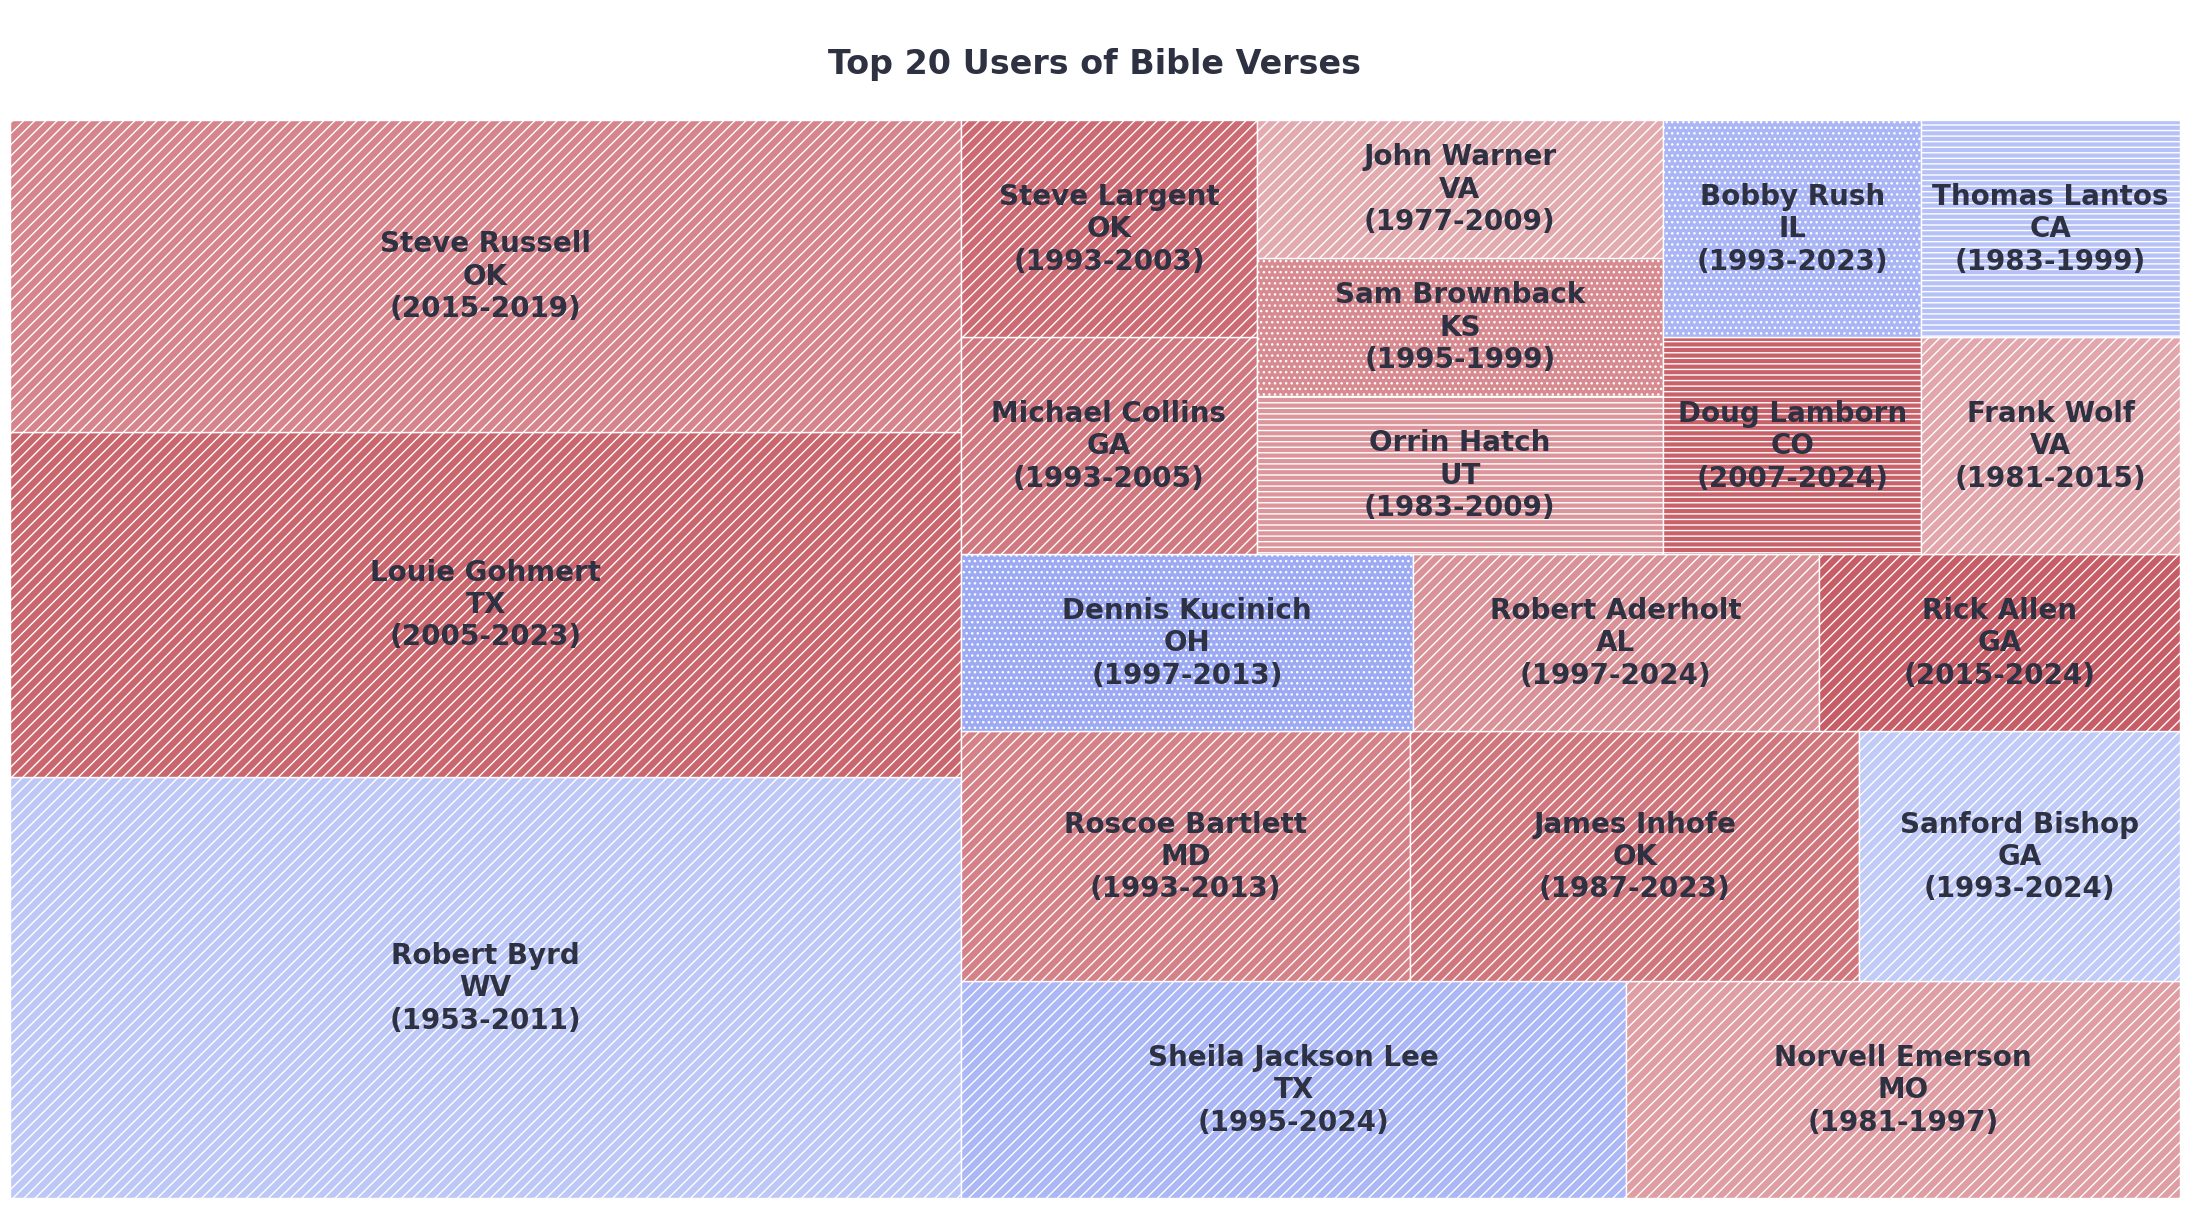

In [78]:
# make sure it works
# url for color scheme: https://coolors.co/2d3142-413c58-c14953-8093f1-edddd4

import pandas as pd 
import squarify 
import matplotlib.pyplot as plt 
  
sns.set(context='notebook', font_scale=3, rc={'figure.figsize':(28,14)}, style='whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'

party_to_color = {'Democrat': '#8093F1', 'Republican': '#C14953'}

# select top 20 speakers
top20_speakers = agg_filtered.loc[:, ["rep_string", "full_name", "p", "val", 'actual_dw_nom', 'state', 'party']].sort_values( 
    by="val", ascending=False)[:20]

def make_full_string(row):
    return row['full_name'] + "\n" + row['rep_string']

def remove_small_val_name(row):
    print(row)
    if int(row['val']) < 5:
        return ""
    return row['full_plot_string']

top20_speakers['full_plot_string'] = top20_speakers.apply(make_full_string, axis=1)
top20_speakers['plot_string'] = top20_speakers.apply(remove_small_val_name, axis=1)

top20_speakers['color'] = top20_speakers['p'].apply(lambda x: party_to_color[x])
top20_speakers['region'] = top20_speakers['state']['first'].apply(lambda x: state_region[x])
# change color's intensity based on dw_nom
def correct_color_for_dw(row):
    color = row['color']
    dw_nom = row['actual_dw_nom']
    return color + hex(int((dw_nom + .2) * 255))[2:]

top20_speakers['color'] = top20_speakers.apply(correct_color_for_dw, axis=1)

plt.axis("off")
axis = squarify.plot(sizes=top20_speakers['val'], 
                     label=top20_speakers['plot_string'],
                     color=top20_speakers['color'],
                     pad=False, 
                     text_kwargs={'fontsize': 20, 'color': '#2D3142'},
                     #edgecolor='grey',  # Set border color
                     #linewidth=2
                     )  # Set border width
hatch_region = {'South': '/ / /', 'West': '- - -', 'Northeast': 'x x x', 'Midwest': '. . .'}
for i,rect in enumerate(axis.patches):
    # Set a different hatch for each bar
    rect.set_hatch(hatch_region[top20_speakers['region'].iloc[i]])

axis.set_title("\nTop 20 Users of Bible Verses\n", fontsize=24, color="#2D3142", weight='bold')
plt.show()

0 0 50.0
1 0 18.0
2 0 10.0
3 0 10.0
4 0 7.0
5 0 7.0
6 0 41.0
7 0 37.0
8 0 15.0
9 0 14.0
10 0 14.0
11 0 9.0
12 0 8.0
13 0 8.0
14 0 8.0
15 0 8.0
16 0 7.0
17 0 7.0
18 0 7.0
19 0 7.0
20 0 0


/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


IndexError: single positional indexer is out-of-bounds

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

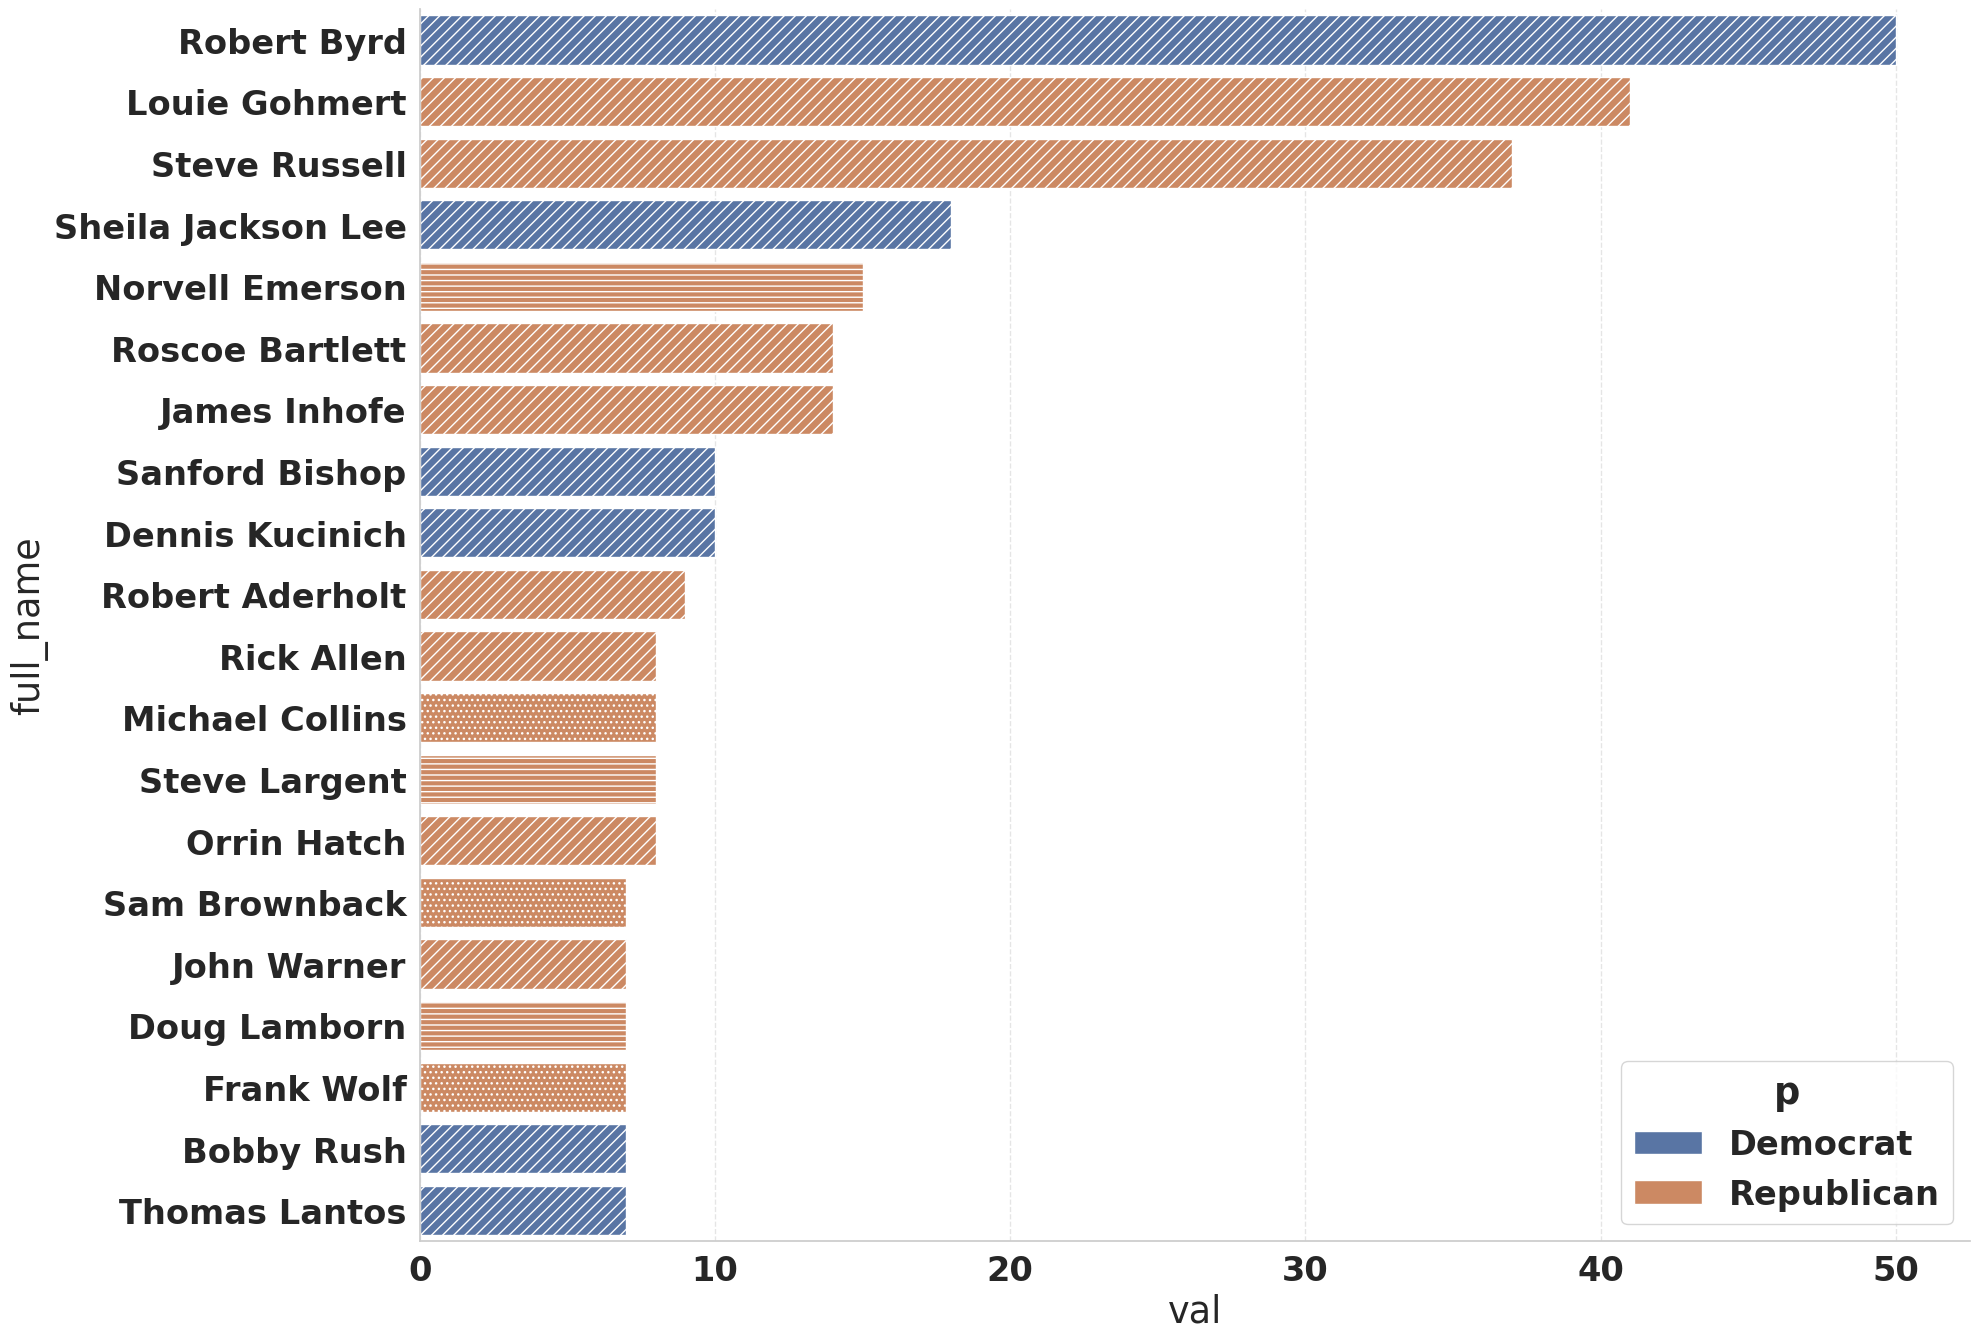

In [250]:
import matplotlib.pyplot as plt
import itertools

hatch_region = {'South': '///', 'West': '...', 'Northeast': 'xxx', 'Midwest': '---'}

bar = sns.barplot(data=top20_speakers, y='full_name', x='val', hue='p', fill='region')
# Set the labels and title
for i,thisbar in enumerate(bar.patches):
    print(i, thisbar.get_x(), thisbar.get_width())
    # Set a different hatch for each bar
    thisbar.set_hatch(hatch_region[top20_speakers['region'].iloc[i]])

plt.show()

plt.ylabel('Name')
plt.xlabel('Verse Count')
plt.title('Top 20 Speakers\' Verse Counts')
plt.legend(title='Party')
# Show the plot
plt.show()